In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [3]:
import tensorflow.keras.layers as layers

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

tf.config.run_functions_eagerly(True)

Found GPU at: /device:GPU:0


In [5]:

! wget  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy


--2021-07-28 02:56:06--  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819200096 (781M)
Saving to: ‘mnist_test_seq.npy’

mnist_test_seq.npy  100%[===================>] 781.25M  45.0MB/s    in 18s     

2021-07-28 02:56:24 (44.0 MB/s) - ‘mnist_test_seq.npy’ saved [819200096/819200096]



In [6]:
data = np.load("./mnist_test_seq.npy")

In [7]:
data.shape

(20, 10000, 64, 64)

In [8]:
data = np.swapaxes(data, 0, 1)

we have 10000 such stacked images (20 frames with 64*64 shape)

In [9]:
data.shape

(10000, 20, 64, 64)

In [10]:
data = np.expand_dims(data, axis = -1)

In [11]:
data.shape

(10000, 20, 64, 64, 1)

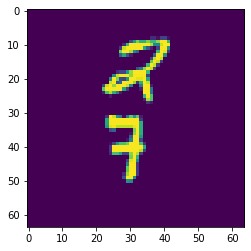

In [12]:
plt.imshow(data[0,0,:,:,:].squeeze())

In [13]:
dataset = data[:1000, :,:,:]

In [14]:
dataset.shape

(1000, 20, 64, 64, 1)

## Splitting dataset into Train and Test Data

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
y = np.random.rand(1000,4)
y.shape
train, test, _, __ =  train_test_split(dataset, y, test_size =  0.2)

In [17]:
print(train.shape, test.shape)

(800, 20, 64, 64, 1) (200, 20, 64, 64, 1)


## Visualizing Data

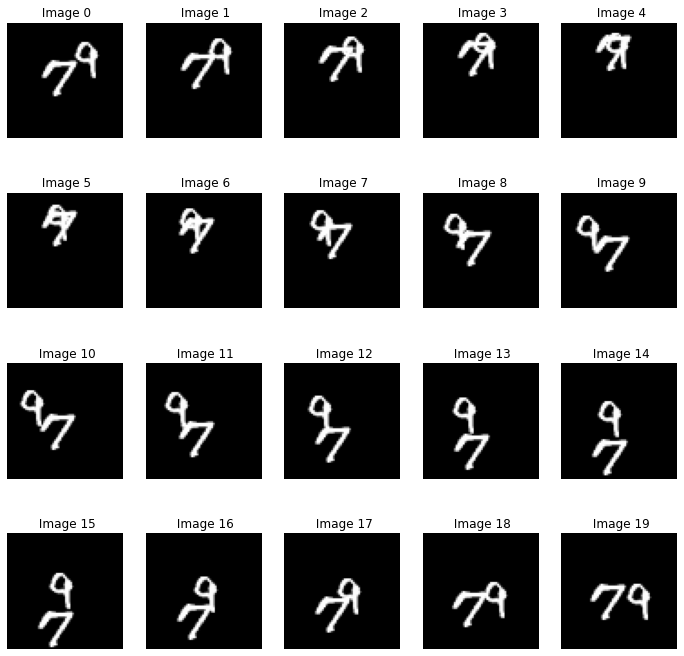

In [18]:
#visualizing the data

fig, axes = plt.subplots(4,5, figsize = (12,12))
#lets display all the frames for sequence 555 from train set
for i, ax in  enumerate(axes.flat):
  #print(type(i))
  img  = train[555, i, :,:,:]
  ax.imshow(img.squeeze(), cmap = "gray")
  ax.set_title(" Image {}".format(i))
  ax.axis("off")
plt.show()

In [19]:
train = train / 255.0
test = test / 255.0

In [20]:
type(test[1,1,1,1,0])

numpy.float64

## Formating Data

In [21]:
def shift(data):
    n = data.shape[1]
    x = data[:, :n-1, : ,:,: ]
    y = data[:, 1:n, : ,:,:]
    return x,y

In [22]:
x_train, y_train = shift(train)
x_test, y_test = shift(test)

In [23]:
print(" x_train : {} , x_test : {}".format(x_train.shape, x_test.shape))
print(" y_train : {} , y_test : {}".format(y_train.shape, y_test.shape))

 x_train : (800, 19, 64, 64, 1) , x_test : (200, 19, 64, 64, 1)
 y_train : (800, 19, 64, 64, 1) , y_test : (200, 19, 64, 64, 1)


In [24]:
print(type(x_train[1,1,1,1,0]))

<class 'numpy.float64'>


## **Creating a Model**

In [25]:
nn = tf.keras.models.Sequential() # we define the model 

In [26]:
#lets define the layers
#input = tf.keras.layers.Input()
#we dont need to define input as nn automatically detects the input size

In [27]:
fl = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size= (5,5), padding= 'same', return_sequences= True, activation="relu" )
nn.add(fl)
fl_b = tf.keras.layers.BatchNormalization()
nn.add(fl_b)
sl = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size= (3,3), padding= 'same', return_sequences= True, activation="relu" )
nn.add(sl)
sl_b = tf.keras.layers.BatchNormalization()
nn.add(sl_b)
tl = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size= (3,3), padding= 'same', return_sequences= True, activation="relu" )
nn.add(tl)
final  = tf.keras.layers.Conv3D(filters=1, kernel_size=(3,3,3), activation="sigmoid", padding= "same")
nn.add(final)

In [28]:
 nn.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(),)

In [29]:

epochs = 50
batch_size = 5

tf.config.get_visible_devices()
nn.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/50
160/160 [==============================] - 192s 1s/step - loss: 0.1280 - val_loss: 0.2678
Epoch 2/50
160/160 [==============================] - 178s 1s/step - loss: 0.0280 - val_loss: 0.2640
Epoch 3/50
160/160 [==============================] - 168s 1s/step - loss: 0.0266 - val_loss: 0.1127
Epoch 4/50
160/160 [==============================] - 173s 1s/step - loss: 0.0264 - val_loss: 0.0350
Epoch 5/50
160/160 [==============================] - 185s 1s/step - loss: 0.0255 - val_loss: 0.0266
Epoch 6/50
160/160 [==============================] - 181s 1s/step - loss: 0.0252 - val_loss: 0.0249
Epoch 7/50
160/160 [==============================] - 179s 1s/step - loss: 0.0249 - val_loss: 0.0253
Epoch 8/50
160/160 [==============================] - 173s 1s/step - loss: 0.0245 - val_loss: 0.0243
Epoch 9/50
160/160 [==============================] - 165s 1s/step - loss: 0.0245 - val_loss: 0.0243
Epoch 10/50
160/160 [==============================] - 179s 1s/step - loss: 0.0244 - val_lo

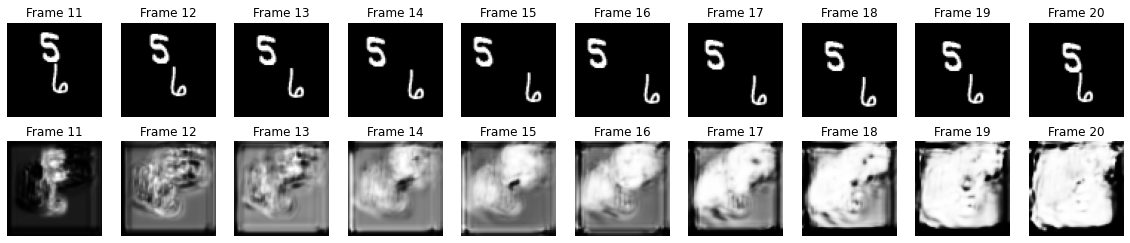

In [31]:
# Select a random example from the validation dataset.
example = test[np.random.choice(range(len(test)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = nn.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()a

In [33]:
# Select a few random examples from the dataset.
examples = test[np.random.choice(range(len(test)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = nn.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction


In [34]:
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, None, 64, 64, 64)  416256    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
_________________________________________________________________
conv3d (Conv3D)              (None, None, 64, 64, 1)   1729      
Total params: 1,008,833
Trainable params: 1,008,577
Non-trainable params: 256
____________________________________________

In [36]:
!mkdir -p saved_model
nn.save('saved_model/my_model')

In [37]:
new_model = tf.keras.models.load_model('saved_model/my_model')

In [38]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, None, 64, 64, 64)  416256    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
_________________________________________________________________
conv3d (Conv3D)              (None, None, 64, 64, 1)   1729      
Total params: 1,008,833
Trainable params: 1,008,577
Non-trainable params: 256
____________________________________________

In [39]:
nn.save('my_model.h5')

In [40]:
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, None, 64, 64, 64)  416256    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
_________________________________________________________________
conv3d (Conv3D)              (None, None, 64, 64, 1)   1729      
Total params: 1,008,833
Trainable params: 1,008,577
Non-trainable params: 256
____________________________________________

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


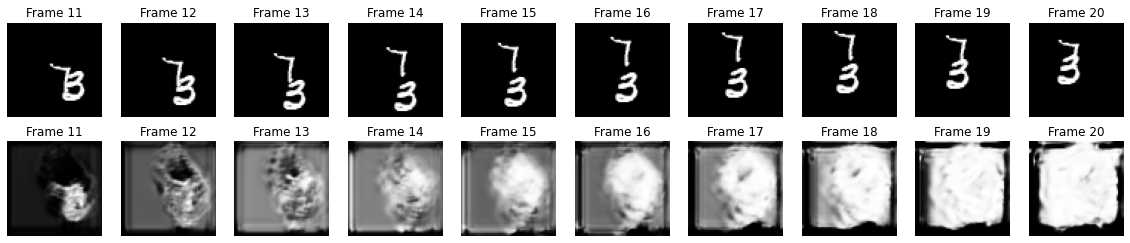

In [42]:
# Select a random example from the validation dataset.
example = test[np.random.choice(range(len(test)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = new_model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

In [43]:
# Select a few random examples from the dataset.
examples = test[np.random.choice(range(len(test)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = new_model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction


In [46]:
imageio.mimsave(predicted_videos)

TypeError: mimwrite() missing 1 required positional argument: 'ims'